<a href="https://colab.research.google.com/github/hderoche/RNN_Bitcoin_Prediction/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tentative de prédiction du Bitcoin par Analyse Technique et Intelligence Artificielle (RNN - LTSM)

Ce Notebook a pour intention d'explorer les possibilités des réseaux de neurones couplés aux indicateurs de l'analyse technique afin de définir une stratégie et de l'automatiser grâce aux bots de trading.

Ces recherches sont développées en plusieures parties : 
1.   Statistiques descriptives
  *   Comprendre le marché volatil Bitcoin
  *   Déduire des statistiques propres à ce marché
2.   Intégration des Indicateurs
  *   Comprendre leur fontionnement et leur pertinence
  *   Déterminer lesquels utiliser pour de l'algotrading
3.   Contruction du modèle RNN
  *   Ajuster les paramètres et les couches du modele TensorFlow-Keras pour le rendre plus performant
  *   Trouver un modele permettant de prédire à h+24 ou d+2
4.   Robot Trading
  *   Mise en place de la stratégie par scoring
  *   Backtesting sur les données historiques
  *   Optimisation de ses paramètres

Les données sont tirées de https://www.cryptodatadownload.com/

Les commentaires sont en français dans le texte, mais par habitudes le nom des variables et les commentaires dans le code sont en anglais.



# Problèmes rencontrés

*   Sur la partie prédictions à plusieurs périodes, il est difficile de trouver un modele permettant une représentation fidèle du cours. Cela parait normal mais le modèle ne peut pas générer des valeurs lui permettant de s'approcher du cours. Plus l'on essaie de prédire loin dans le temps plus les valeurs s'éloignent.


## Importing

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layer
from sklearn.preprocessing import MinMaxScaler

In [226]:
import pandas_datareader as web

In [227]:
dfff = web.DataReader('BTC-USD', data_source='yahoo', start='2015-01-01', end='2021-01-03')
dfff

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007
2015-01-05,278.341003,265.084015,265.084015,274.473999,43962800,274.473999
...,...,...,...,...,...,...
2020-12-31,29244.876953,28201.992188,28841.574219,29001.720703,46754964848,29001.720703
2021-01-01,29600.626953,28803.585938,28994.009766,29374.152344,40730301359,29374.152344
2021-01-02,33155.117188,29091.181641,29376.455078,32127.267578,67865420765,32127.267578


In [228]:
path = './Bitstamp_BTCUSD_d.csv'

data = pd.read_csv(path, header=0, sep=';')
data['diff'] = data['close'] - data['open']
data = data.drop(['date', 'symbol'], axis=1)
data = data[::-1]
data['index'] = np.arange(data.shape[0])
data = data.reset_index(drop=True)
print(data.head())

         unix    open    high     low  ...  Volume BTC  Volume USD   diff  index
0  1417132800  363.59  381.34  360.57  ...  3220878.18     8617.15  12.69      0
1  1417219200  376.42  386.60  372.25  ...  2746157.05     7245.19   0.30      1
2  1417305600  376.57  381.99  373.32  ...  1145566.61     3046.33  -3.23      2
3  1417392000  376.40  382.31  373.03  ...  2520662.37     6660.56   1.99      3
4  1417478400  378.39  382.86  375.23  ...  2593576.46     6832.53   0.86      4

[5 rows x 9 columns]


## Statistiques Descriptives sur le Bitcoin

### Volatilité et Volume (Correlation)

In [229]:
def volatility_max():
  data['vol'] = data['high'].sub(data['low'], axis=0)
  print(data.head())
volatility_max()

         unix    open    high     low  ...  Volume USD   diff  index    vol
0  1417132800  363.59  381.34  360.57  ...     8617.15  12.69      0  20.77
1  1417219200  376.42  386.60  372.25  ...     7245.19   0.30      1  14.35
2  1417305600  376.57  381.99  373.32  ...     3046.33  -3.23      2   8.67
3  1417392000  376.40  382.31  373.03  ...     6660.56   1.99      3   9.28
4  1417478400  378.39  382.86  375.23  ...     6832.53   0.86      4   7.63

[5 rows x 10 columns]


On calcule la volatilité comme la différence entre le point le plus haut et le point le plus bas de la même période

Ensuite, je normalise les valeurs pour permettre de rendre les calculs plus rapides.

In [230]:
# Pre-processing for display
def normalize(df):
    result = df.copy()
    for feature_name in result.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

dataN = normalize(data)
dfCorrelationN = pd.DataFrame()
dfCorrelationN['volumeBTC'] = dataN['Volume BTC']
dfCorrelationN['volatility'] = dataN['vol']
print(dfCorrelationN.head())
print(dfCorrelationN.corr())
corr_volBTC_vol = dfCorrelationN.corr()['volatility'][0]

   volumeBTC  volatility
0   0.004170    0.004480
1   0.003556    0.003096
2   0.001483    0.001870
3   0.003264    0.002002
4   0.003358    0.001646
            volumeBTC  volatility
volumeBTC    1.000000    0.612587
volatility   0.612587    1.000000


On obtient une corrélation entre la volatilité et le volume de **0.61** soit **61%**

Cela veut dire que lorsque la volatilité augmente, dans 61% du temps cela résulte d'un plus grand volume.

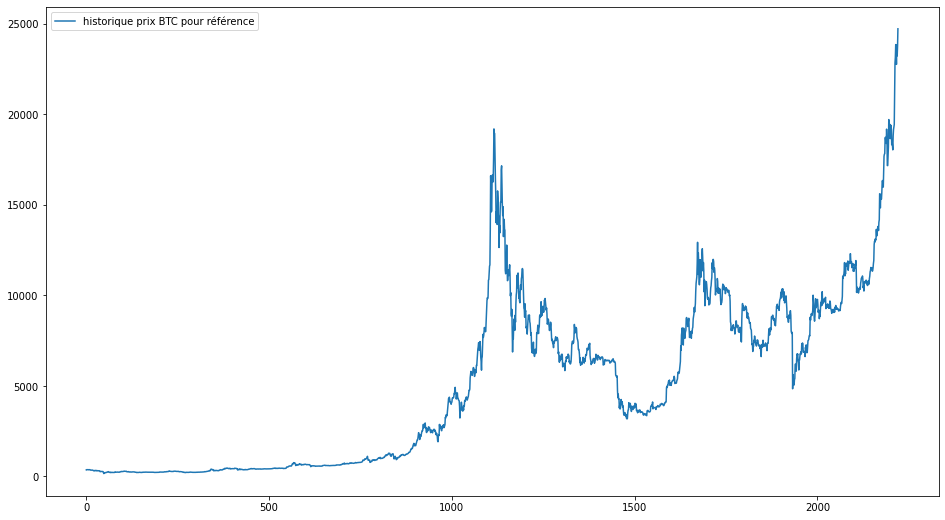

In [231]:
plt.figure(figsize=[16,9])
dataTemp = data.reset_index()
plt.plot(dataTemp['open'], label='historique prix BTC pour référence')
plt.legend()


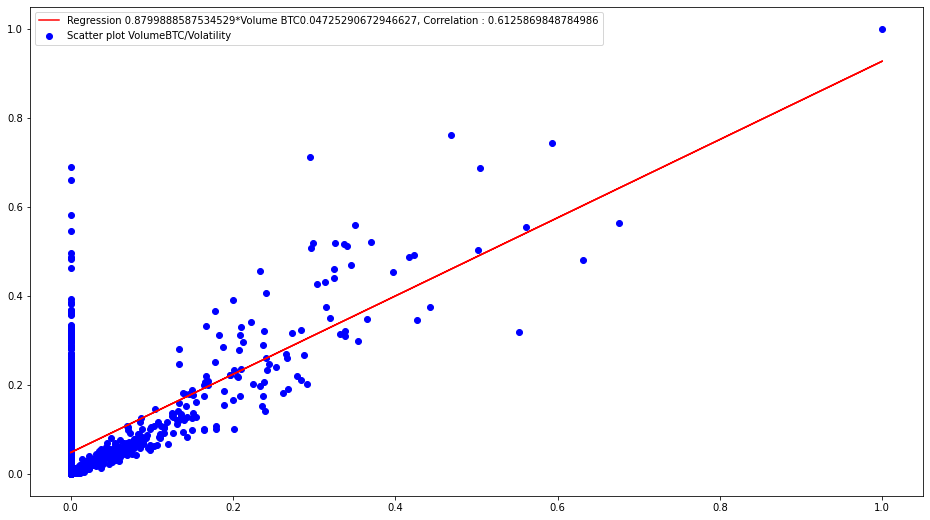

In [232]:
plt.figure(figsize=[16,9])
plt.scatter(dfCorrelationN['volumeBTC'], dfCorrelationN['volatility'], color='blue', 
         label='Scatter plot VolumeBTC/Volatility')

# Droite de régression
m, b = np.polyfit(dfCorrelationN['volumeBTC'], dfCorrelationN['volatility'], 1)

plt.plot(dfCorrelationN['volumeBTC'], m*dfCorrelationN['volumeBTC'] + b, color='red', 
         label='Regression ' + str(m) + '*Volume BTC'+ str(b) + ', Correlation : ' + str(corr_volBTC_vol))
plt.legend()
plt.show()

On peut voir la correlation entre le volume et la volatilité



       unix      open      high  ...      diff     index       vol
0  0.000000  0.008211  0.006860  ...  0.513422  0.000000  0.004480
1  0.000450  0.008733  0.007074  ...  0.511388  0.000450  0.003096
2  0.000901  0.008739  0.006886  ...  0.510808  0.000901  0.001870
3  0.001351  0.008732  0.006899  ...  0.511665  0.001351  0.002002
4  0.001802  0.008814  0.006921  ...  0.511480  0.001802  0.001646

[5 rows x 10 columns]
   level_0      unix      open  ...      diff     index       vol
0     2220  1.000000  1.000000  ...  0.495046  1.000000  0.051019
1     2219  0.999550  0.960623  ...  0.668606  0.999550  0.296220
2     2218  0.999099  0.938946  ...  0.595277  0.999099  0.232768
3     2217  0.998649  0.963550  ...  0.417535  0.998649  0.317533
4     2216  0.998198  0.920009  ...  0.689472  0.998198  0.314866

[5 rows x 11 columns]


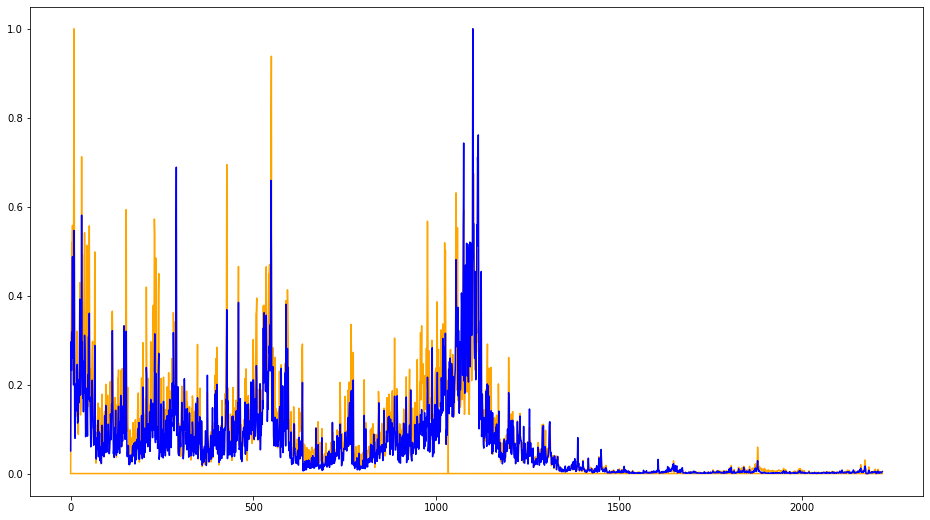

In [233]:
# removing noisy data

print(dataN.head())
dataN = dataN[::-1].reset_index()
print(dataN.head())
plt.figure(figsize=[16,9])
plt.plot(dataN['Volume BTC'], color='orange')
plt.plot(dataN['Volume USD'], color='orange')
plt.plot(dataN['vol'], color='blue')
plt.plot()
plt.show()

### Moyenne des pourcentages volatilité

In [234]:
data['diff'] = data['close'] - data['open']
print(data.head())
data['per'] = ( data['diff']*100 )/data['open']

meanVolatilityPercentage = data['per'].mean()
minVolatilityPercentage = data['per'].min()
maxVolatilityPercentage = data['per'].max()
print('mean',meanVolatilityPercentage)
print('max',maxVolatilityPercentage)
print('min',minVolatilityPercentage)

         unix    open    high     low  ...  Volume USD   diff  index    vol
0  1417132800  363.59  381.34  360.57  ...     8617.15  12.69      0  20.77
1  1417219200  376.42  386.60  372.25  ...     7245.19   0.30      1  14.35
2  1417305600  376.57  381.99  373.32  ...     3046.33  -3.23      2   8.67
3  1417392000  376.40  382.31  373.03  ...     6660.56   1.99      3   9.28
4  1417478400  378.39  382.86  375.23  ...     6832.53   0.86      4   7.63

[5 rows x 10 columns]
mean 0.26124685072043163
max 28.895061728395063
min -39.14663744031452


*   La moyenne de volatilité est de **0.26%**
*   Le max de volatilité est de **28.9%**
*   Le min de volatilité est de **-39.1%**




### Jour Up Down Neutre



In [235]:
def count_up_down_period(data):
  up_days = 0
  down_days = 0
  neutral_days = 0
  for i in range(data.shape[0]):
    if data['diff'][i] > 0:
      up_days+=1
    elif data['diff'][i] < 0:
      down_days+=1
    elif data['diff'][i] == 0:
      neutral_days+=1
  return up_days, down_days, neutral_days

In [236]:
up, down, neutral = count_up_down_period(data)
print('number of up days : ',up)
print('number of down days : ',down)
print('number of neutral days : ',neutral)

number of up days :  1198
number of down days :  1012
number of neutral days :  11


### Statistiques par année

In [237]:
def stats(data):
  mean.append(data['close'].mean())
  max.append(data['close'].max())
  min.append(data['close'].min())
  data['diff'] = data['close'] - data['open']
  data['per'] = ( data['diff']*100 )/data['open']
  vol.append(data['per'].mean())
  volumeBTC.append(data['Volume BTC'].mean())
  volumeUSD.append(data['Volume USD'].mean())

In [238]:
year_data = data.copy()
year_data['date'] = pd.to_datetime(year_data['unix'], unit='s')
year_data['year'] = year_data['date'].dt.year

unique_year = year_data['year'].drop_duplicates()
year_data = year_data.drop(['unix', 'date'], axis=1)

max = []
min = []
mean = []
vol = []
volumeUSD = []
volumeBTC = []
years = ['all history']

stats(year_data)
# Iteration sur chaque année
for year in unique_year:
  # selection des données
  mask = year_data['year'] == year
  strY = str(year)
  temp_data = year_data.loc[mask]
  temp_data = temp_data.reset_index()
  years.append(year)

  ## Stats
  stats(temp_data)


# Ajout des données dans le dataframe Pandas
df_year = pd.DataFrame(years)
df_year = df_year.set_index([0])
df_year['min'] = min
df_year['moyenne'] = mean
df_year['max'] = max
df_year['vol moyenne'] = vol
df_year['Volume BTC'] = volumeBTC
df_year['Volume USD'] = volumeUSD


print(df_year.to_string())

                 min       moyenne       max  vol moyenne    Volume BTC    Volume USD
0                                                                                    
all history   162.00   5011.061396  24705.15     0.261247  1.587456e+07  3.369355e+07
2014          311.94    344.781176    379.25    -0.381627  2.844332e+06  8.341504e+03
2015          162.00    272.140110    463.61     0.119211  4.032125e+06  1.436841e+04
2016          367.64    566.694317    975.97     0.250185  2.979942e+06  5.329448e+03
2017          788.81   3972.231096  19187.78     0.859005  5.930721e+07  1.281281e+04
2018         3179.54   7522.233863  17149.67    -0.258512  2.998677e+07  5.437589e+07
2019         3359.33   7363.344055  12920.54     0.241781  8.204384e+03  6.363052e+07
2020         4841.67  10880.895429  24705.15     0.417437  8.351459e+03  8.794705e+07


Statistiques par année du bitcoin

On remarque que les années de bull run (2017, fin 2020), la volatilité moyenne du bitcoin est plus haute que la moyenne

Et les années de Bear Market (2014,2018) ont des volatilités négatives

En regardant de plus près, on peut voir que la moyenne exponentielle Fibonnacci colle bien la courbe des prix et rebondit lorque le cours se rapproche de celle ci.

## Indicateurs

#### RSI

In [239]:
# RSI integration to the dataset
param = 14
def RSI(data, param): 
    dataLength = len(data)
    priceUp = []  
    priceDown = []
    k = 0
    while k < dataLength:
        if k == 0:
            priceUp.append(0)
            priceDown.append(0)
        else:
            diff = data['open'][k] - data['open'][k-1]
            if diff > 0:
                priceUp.append(diff)
                priceDown.append(0)
            elif diff <= 0:
                priceDown.append(diff)
                priceUp.append(0)
        k+=1
    avgGain = []
    avgLoss = []
    i = 0
    while i < dataLength:
        if i < param + 1:
            avgGain.append(0)
            avgLoss.append(0)
        else:
            avgGain.append(sum([priceUp[i-l] for l in range(0, param + 1)]) / param)
            avgLoss.append(np.abs(sum([priceDown[i-l] for l in range(0, param + 1)]) / param))
        i += 1
    RS = []
    RSI = []
    m = 0
    while m < dataLength:
        if avgGain[m] == 0 and avgLoss[m] == 0:
            RS_TempValue = 0
        else: 
            RS_TempValue = avgGain[m]/avgLoss[m]
        RS.append(RS_TempValue)
        RSI_TempValue = 100 - (100 / (1 + RS_TempValue))
        RSI.append(RSI_TempValue)
        m += 1
    data['RSI'] = RSI
    return data

data = RSI(data, param)

#### MA

In [240]:
def moving_average(data, param):
  data['MA' + str(param)] = data.iloc[:,1].rolling(window=param).mean().fillna(0)
  return data

data = moving_average(data, 200)

#### FMA (Fibonacci Moving Average)

In [241]:
def fibonacci(n):
  if n <= 1:
      return n
  else:
      return fibonacci(n-1) + fibonacci(n-2)

def FMA(n):
  fibo = []
  [fibo.append(fibonacci(i)) for i in range(3, n + 3)]
  print(fibo)
  temp_df = pd.DataFrame()
  temp_df['FMA'] = np.zeros(data.shape[0])
  for coeff in fibo:
    temp_df['FMA'] = temp_df['FMA'] + data.iloc[:, 1].ewm(span=param).mean()
  temp_df['FMA'] = temp_df['FMA']/len(fibo)
  print(temp_df)
  data['FMA'] = temp_df['FMA']
  return data

data = FMA(12)
print(data.tail())

[2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377]
               FMA
0       363.590000
1       370.463214
2       372.796027
3       373.898584
4       375.070388
...            ...
2216  21222.810836
2217  21568.980058
2218  21788.449384
2219  22049.618799
2220  22404.870959

[2221 rows x 1 columns]
            unix      open      high  ...        RSI        MA200           FMA
2216  1608595200  22750.07  23843.21  ...  69.277800  12565.27195  21222.810836
2217  1608681600  23819.08  24096.90  ...  74.159389  12636.28650  21568.980058
2218  1608768000  23215.00  23779.14  ...  76.288254  12703.99610  21788.449384
2219  1608854400  23747.22  24777.00  ...  77.020383  12773.93700  22049.618799
2220  1608940800  24714.01  24768.79  ...  81.393600  12848.57385  22404.870959

[5 rows x 14 columns]


#### Exponential Moving Average

In [242]:
def exponential_moving_average(data, param):
  data['EMA' + str(param)] = data.iloc[:, 1].ewm(span=param).mean()
  data = data[::-1]
  return data


Moving Average on Volume

In [243]:
def moving_average_on_volume(data, param, typeVol):
  data['VOL_MA' + str(param) + str(typeVol)] = data['Volume ' + str(typeVol)].rolling(window=param).mean()
  data = data[::-1]
  return data

#### Visualisation

In [244]:
moving_average(data, 200)
moving_average_on_volume(data, 21, 'USD')
moving_average_on_volume(data, 21, 'BTC')
exponential_moving_average(data, 13)['EMA13']

2220    22542.879416
2219    22181.024319
2218    21919.991705
2217    21704.156989
2216    21351.669821
            ...     
4         375.127311
3         373.945756
2         372.841024
1         370.498462
0         363.590000
Name: EMA13, Length: 2221, dtype: float64

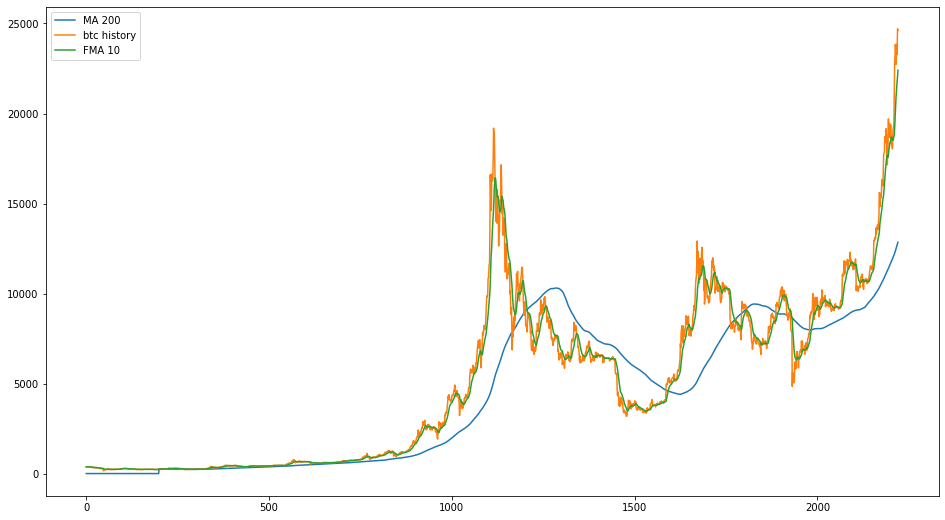

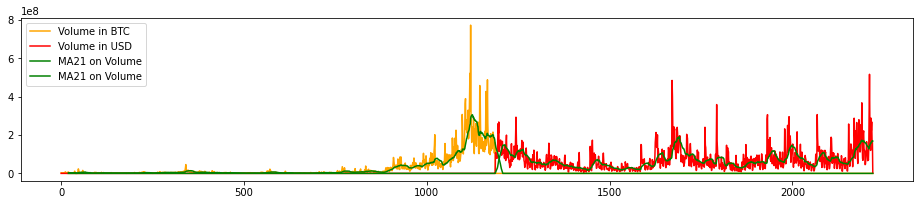

In [245]:
dataTemp = data.reset_index()
plt.figure(figsize=[16, 9])
plt.plot(data['MA200'], label='MA 200')
plt.plot(data['close'], label='btc history')
plt.plot(data['FMA'], label='FMA 10')
plt.legend()
plt.figure(figsize=[16,3])
plt.plot(dataTemp['Volume BTC'], color="orange", scaley='log', label="Volume in BTC")
plt.plot(dataTemp['Volume USD'], color="red", scaley='log', label="Volume in USD")
plt.plot(dataTemp['VOL_MA21USD'], color='green', scaley='log', label="MA21 on Volume")
plt.plot(dataTemp['VOL_MA21BTC'], color='green', scaley='log', label="MA21 on Volume")
plt.legend()
plt.show()

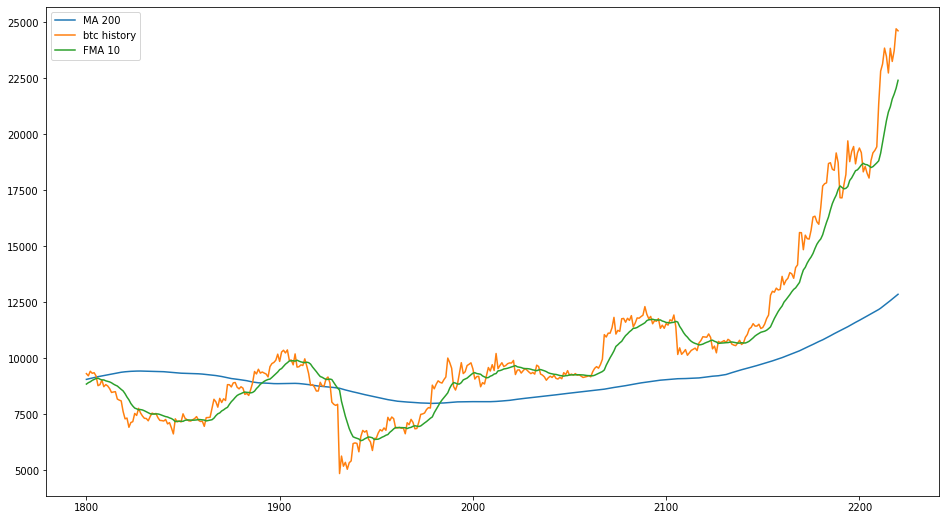

In [246]:
sm_data = data.copy()
sm_data = sm_data[1800:]

plt.figure(figsize=[16, 9])
plt.plot(sm_data['MA200'], label='MA 200')
plt.plot(sm_data['close'], label='btc history')
plt.plot(sm_data['FMA'], label='FMA 10')
plt.legend()
plt.show()

On remarque que les données au niveau des volumes ne sont pas très fiables. On observe que le volume d'échange au niveau des BTC était plus grand avant la bulle de 2017. Depuis, c'est le volume USD qui prédomine, cela s'explique par la valeur du Bitcoin qui augmente.

On a besoin de moins de Bitcoin pour un même montant


---



Sur ces graphiques on peut voir que les moyennes mobiles permettent éventuellement d'avoir de l'information sur un changement de tendance.

Si la moyenne mobile se trouve au dessus du cours alors la tendance est à la vente

Dans le cas contraire, la tendance est à l'achat.

En se basant sur ces informations on peut par exemple scorer avec des règles préécrites pour que le robot puisse soit acheter soit vendre si un nombre suffisant de règles sont validées

## AI Model

### Data Selection

Splitting the data into two parts

1.   Training data
2.   Testing data

The split_index is the percentage of the training data over the testing data


In [247]:
# Reading data and adding a column to have an index
path = './Bitstamp_BTCUSD_d.csv'

data = pd.read_csv(path, header=0, sep=';')
#dataBitstamp = pd.read_csv('Bitstamp_BTCUSD_d.csv', header=0, sep=',')
# This dataset has a column of Timstamp

#dataBitstamp = dataBitstamp.drop(['Unix Timestamp'], axis=1)
dataBitstamp = data.drop(['unix'], axis=1)
# Data processing and slicing dataframe in order to have the right dimension to input in the RNN
data = pd.DataFrame(dataBitstamp, index=[i for i in range(dataBitstamp.shape[0])])
# The datafiles I had were reversed, meaning that the index of the lastest data was 0, so I had to reverse the dataframe
data = data.drop(['date','symbol', 'Volume USD'], axis=1)
print(data.head())
data = data[::-1]
#data = data.drop(['Date','Symbol', 'Volume USD'], axis=1)
print(data.shape)
data = RSI(data, 14)
data = moving_average(data, 50)
data = exponential_moving_average(data,21)
print(data.head())


       open      high       low     close    Volume BTC
0  24714.01  24768.79  24532.28  24614.77     66.019462
1  23747.22  24777.00  23403.82  24705.15   6469.228973
2  23215.00  23779.14  22700.10  23726.28   7185.482055
3  23819.08  24096.90  22624.92  23247.71  11541.969371
4  22750.07  23843.21  22383.59  23835.10   9367.609483
(2221, 5)
       open      high       low  ...        RSI        MA50         EMA21
0  24714.01  24768.79  24532.28  ...  55.930217  19469.6414  22219.312681
1  23747.22  24777.00  23403.82  ...  68.631548  19293.6452  21964.364949
2  23215.00  23779.14  22700.10  ...  69.371881  19113.5168  21683.101444
3  23819.08  24096.90  22624.92  ...  69.295277  18923.4840  21473.497589
4  22750.07  23843.21  22383.59  ...  77.680577  18723.2212  21211.157347

[5 rows x 8 columns]


[7.50224272e-01 1.27574524e-01 1.13138149e-01 8.21470846e-03
 4.39708015e-04 2.22614594e-04 1.57512635e-04 2.85111485e-05]


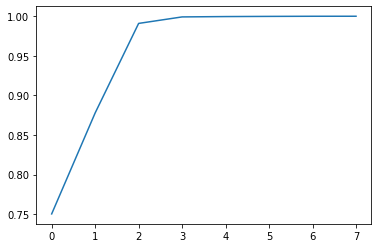

In [248]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

md = data.copy()
md = md[::-1]

mScaler = StandardScaler()
md_std = mScaler.fit_transform(md)

pca = PCA()
pca.fit(md_std)
evr = pca.explained_variance_ratio_
print(evr)

plt.plot(evr.cumsum())
plt.show()

In [249]:
data.corr()

,open,high,low,close,Volume BTC,RSI,MA50,EMA21
open,1.000000,0.998910,0.998236,0.997954,0.257773,-0.021980,0.961796,0.990245
high,0.998910,1.000000,0.997764,0.999076,0.270058,-0.022192,0.960545,0.989594
low,0.998236,0.997764,1.000000,0.998855,0.228902,-0.019261,0.960506,0.988042
close,0.997954,0.999076,0.998855,1.000000,0.253670,-0.019541,0.959285,0.988179
Volume BTC,0.257773,0.270058,0.228902,0.253670,1.000000,-0.053274,0.230479,0.262408
RSI,-0.021980,-0.022192,-0.019261,-0.019541,-0.053274,1.000000,-0.047946,-0.031218
MA50,0.961796,0.960545,0.960506,0.959285,0.230479,-0.047946,1.000000,0.986257
EMA21,0.990245,0.989594,0.988042,0.988179,0.262408,-0.031218,0.986257,1.000000


In [250]:
# In percentage
split_index = 70
data_AI = data.copy()
print(data_AI.columns)
data_AI = data_AI.drop(['close', 'Volume BTC', 'RSI', 'MA50', 'EMA21'], axis=1)
print(data_AI.columns)
index = int(np.floor(abs(data_AI.shape[0] * split_index/100)))

data_train, data_test = data_AI.loc[:index, :], data_AI.loc[index + 1:, :]

print(data_train.shape)
print(data_test.shape)


Index(['open', 'high', 'low', 'close', 'Volume BTC', 'RSI', 'MA50', 'EMA21'], dtype='object')
Index(['open', 'high', 'low'], dtype='object')
(1555, 3)
(666, 3)


In [251]:
scaler = MinMaxScaler(feature_range=(0,1))
data_training, data_testing = scaler.fit_transform(data_train), scaler.fit_transform(data_test)
L_min = []
for i in range(data_test.shape[1]):
  L_min.append(np.min(data_test.iloc[:,i]))
## Getting the data for the train and test part
x_train = []
y_train = []

def data_selection(data_to_select):
    X = []
    y = []
    for i in range(data_to_select.shape[0] - 60):
        subset = []
        y.append(data_to_select[i + 60, :])
        for j in range(60):
            subset.append(data_to_select[i + j])
        X.append(subset)
    X,y = np.array(X),np.array(y)

    return X, y

x_test = []
y_test = []
x_train = []
y_train = []

for i in range(60, data_train.shape[0] - 1):
    x_train.append(data_training[i - 60:i])
    y_train.append(data_training[i + 1, :])

for i in range(60, data_test.shape[0] - 1):
    x_test.append(data_testing[i-60:i])
    y_test.append(data_testing[i + 1, :])

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

print(x_test.shape)
print(x_train.shape)

(605, 60, 3)
(1494, 60, 3)


### Contruction du modele

In [252]:
def AI_model():
    model = tf.keras.Sequential()

    model.add(layer.LSTM(units = 600, activation=tf.nn.relu, return_sequences=True, input_shape= (x_train.shape[1], x_train.shape[2])))
    model.add(layer.Dropout(0.4))
    model.add(layer.LSTM(units = 600, activation=tf.nn.relu, return_sequences=True))
    model.add(layer.Dropout(0.2))
    model.add(layer.LSTM(units=600, activation=tf.nn.relu))
    model.add(layer.Dropout(0.2))
    model.add(layer.Dense(60))
    model.add(layer.Dense(x_train.shape[2]))


    # As this is a regression model, we want to calulate the price of the asset for the next day, we use the mean sqaured error as a loss funtion.
    # The adam optimizer is the standard in the AI libraries.
    model.compile(optimizer='adam',
                  loss = 'mean_squared_error')

     # Show how the RNN is structured and how many parameters there is.
    print(model.summary())

    # Fitting the model to the train dataset
    # Changing the epoch number will decrease the render time

    model.fit(x_train, y_train, epochs=5, batch_size=32)


    # Saving the model
    model.save('btcAI')

In [253]:
#AI_model()

#### Modele \#1 Prédiction de la valeur suivante

Ce modele permet de prévoir la valeur de la période suivante, et ainsi d'avoir la bonne direction (achat/vente)

In [254]:
# Loading the model from the file in the same repository
new_model = tf.keras.models.load_model('btcAI')
#print(X_test[:6])
print(x_test.shape)
x_test = x_test[::-1]
# Getting the results on the test dataset
y_preds = new_model.predict(x_test, use_multiprocessing=True)

#first_y = new_model.predict(X_test)
#print(first_y)
print(y_test.shape)

# Unscaling the data, in order to have the real results
# This step can be a source of error because we might loose some information by unscaling the data and deforming it
for i in range(y_test.shape[1]):
  scale = scaler.scale_[i]
  y_test[:, i] = y_test[:, i]/scale + L_min[i]
  y_preds[:, i] = y_preds[:, i]/scale + L_min[i]
y_test = y_test[::-1]

# Printing the latest value for the predicted value and the real value
print("Last real value : ", y_test[-1])
print("Last predicted value : ",y_preds[-1])


(605, 60, 3)
(605, 3)
Last real value :  [655.52 665.   651.99]
Last predicted value :  [604.76746 646.313   562.2812 ]


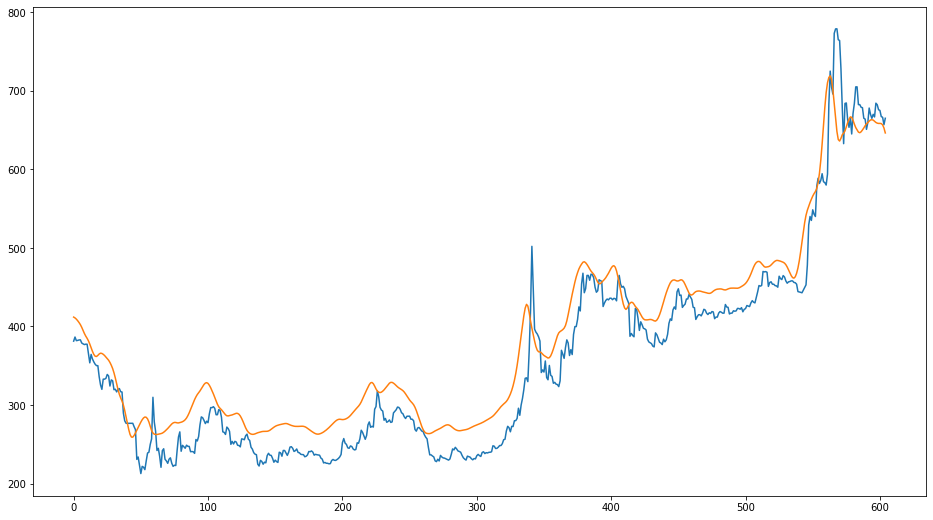

In [255]:
plt.figure(figsize=[16, 9])
plt.plot(y_test[:,1], label="price history")
plt.plot(y_preds[:, 1], label="prediction")
plt.show()

In [256]:
## Difference

def get_difference(y_test, y_preds):
  df_AImodel = pd.DataFrame(y_test[:, 1], columns=['test'])
  df_AImodel['preds'] = y_preds[:, 1]
  df_AImodel['diff_test'] = df_AImodel['test'].diff()
  df_AImodel['diff_pred'] = df_AImodel['preds'].diff()
  trend = []
  for i in range(df_AImodel.shape[0]):
    res = df_AImodel.iloc[i, 2]*df_AImodel.iloc[i, 3]
    if res >= 0:
      trend.append(1) 
    else: 
      trend.append(0)
  df_AImodel['trend'] = trend
  print('predicts the same trend ',(df_AImodel['trend'].sum()/df_AImodel.shape[0])*100, '% of the time')
  return df_AImodel

df_AImodel = get_difference(y_test, y_preds)
df_AImodel

predicts the same trend  50.247933884297524 % of the time


,test,preds,diff_test,diff_pred,trend
0,381.34,411.980743,NaN,NaN,0
1,386.60,410.913025,5.26,-1.067719,0
2,381.99,409.357178,-4.61,-1.555847,1
3,382.31,407.347412,0.32,-2.009766,0
4,382.86,405.031464,0.55,-2.315948,0
...,...,...,...,...,...
600,675.00,658.474915,-0.81,0.048584,0
601,667.10,658.221436,-7.90,-0.253479,1
602,666.30,656.658691,-0.80,-1.562744,1
603,656.77,652.643311,-9.53,-4.015381,1


#### Modele \#2 Prédiction à plusieurs périodes

Ici le meme modele est appliqué, cependant il ne se sert que des 60 premières valeurs, ensuite l'algorithme utilise ses prédictions pour faire les prédictions suivantes.

Ce modele est beaucoup moins précis mais a le mérite de se servir de ses propres résultats pour continuer à prédire.

In [257]:

# for i in range(60, data_test.shape[0] - 1):
#     x_test.append(data_testing[i-60:i])

def select(data, i):
  return data[i - 60:i]

def prediction():
  
  all_pred = x_test.copy()
  all_pred = all_pred[::-1]
  all_data_test = data_testing.copy()
  all_data_test = all_data_test[::-1]
  print(all_pred.shape[0])
  
  for i in range(60, all_pred.shape[0] - 1):
    all_pred[i] = select(all_data_test, i)
    all_pred[i+1] = select(all_data_test, i+1)
    next_pred = new_model.predict(all_pred[i:i+1, :])
    #print(i, next_pred[0])
    all_data_test[i + 2] = next_pred[0]
  all_data_test = all_data_test[:len(all_data_test)-60]
  return all_data_test


predictions = prediction()


605


In [258]:
for i in range(predictions.shape[1]):

  scale = scaler.scale_[i]
  predictions[:, i] = predictions[:, i]/scale + L_min[i]


print(x_test.shape)

(605, 60, 3)


In [259]:
#predictions = predictions[::-1]
print(predictions.shape)
print(y_test.shape)
df_use_pred = pd.DataFrame(y_test[:, 1], columns=['test'])
df_use_pred['pred'] = predictions[:-1, 1]
df_use_pred['diff'] = df_use_pred['test'] - df_use_pred['pred']
print('last value for next period :',predictions[-1, 1])
df_use_pred[55:80]

(606, 3)
(605, 3)
last value for next period : 416.1043199554085


,test,pred,diff
55,239.00,239.000000,0.000000
56,240.00,240.000000,0.000000
57,249.99,249.990000,0.000000
58,257.00,257.000000,0.000000
59,309.90,309.900000,0.000000
60,278.51,278.510000,0.000000
61,266.45,266.450000,0.000000
62,242.18,263.189196,-21.009196
63,244.98,268.200852,-23.220852
64,234.80,273.833877,-39.033877


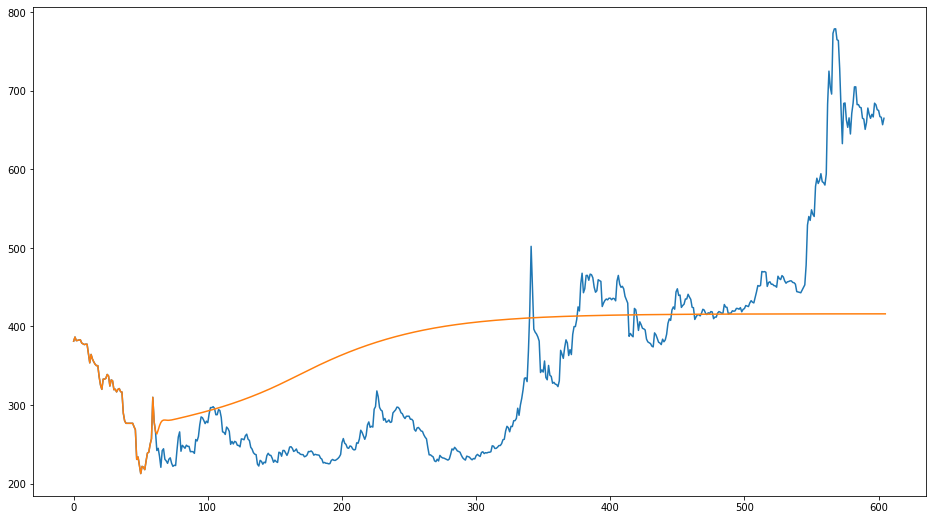

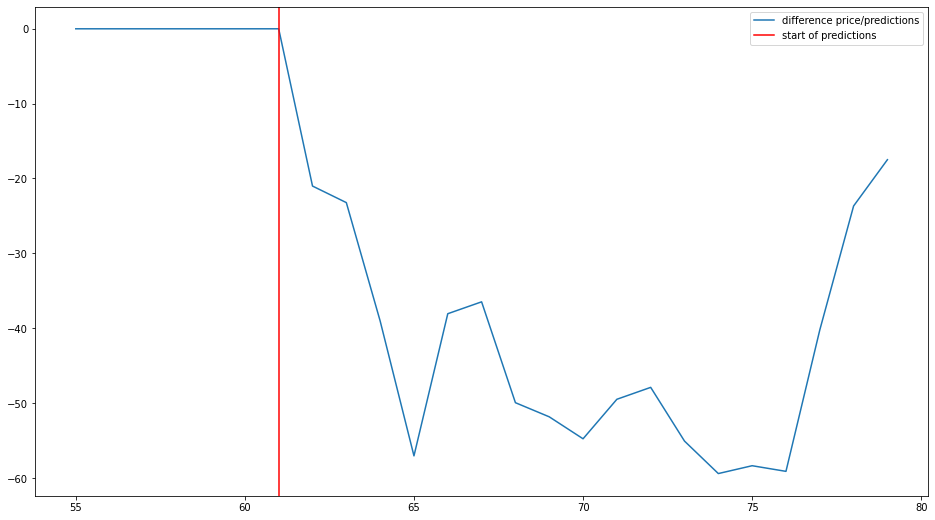

In [260]:

plt.figure(figsize=[16, 9])
plt.plot(y_test[:, 1])
plt.plot(predictions[:, 1])
plt.figure(figsize=[16, 9])
plt.plot(df_use_pred['diff'][55:80], label='difference price/predictions')
plt.axvline(x=61, color='red', label='start of predictions')
plt.legend()
plt.show()

Les résultats ne permettent pas de déterminer une stratégie en utilisant les prédictions pour prédire une tendance. Dès lors que le modele n'a plus de données récentes il ne parvient pas à prendre de décision.

## Bot

Ici je créé le bot pour pouvoir récupérer les stats des trades, et permettre de simplifier le code.

Il sera alors possible d'instancier un nouveau bot pour une autre paire d'actif.

In [261]:
class Bot():
  def __init__(self):
    self.nb_trade = 0
    self.nb_long = 0
    self.nb_short = 0
    self.open_position = 0
    self.price_on_entry = -1
    self.time_on_entry = -1
    self.roe = []
    self.delta = []
    self.trade = []
    self.money = 1000

  def entry(self):
    return self.price_on_entry
  
  def money(self):
    return self.money
  
  def long(self, data):
    if self.money <= 0:
      return 'No money'
    if self.on_position() == False:
      self.nb_trade += 1
      self.nb_long += 1
      self.open_position += 1
      self.price_on_entry = data['open']
      self.time_on_entry = data['index']
    else:
      return 'Already on position'

  def short(self, data):
    if self.money <= 0:
      return 'No money'
    if self.on_position() == False:
      self.nb_trade += 1
      self.nb_short += 1
      self.open_position += 1
      self.price_on_entry = data['open']
      self.time_on_entry = data['index']
    else:
      return 'Already on position'
  
  def close_long(self, data):
    if self.on_position() == True:
      self.open_position -= 1
      diff = data['open'] - self.price_on_entry
      self.delta.append(diff)
      ROE = (diff/self.price_on_entry)*100
      self.roe.append(ROE)
      t = Trade(self.nb_trade, 'long', diff, ROE, self.money, self.price_on_entry, data['open'], self.time_on_entry, data['index'])
      self.trade.append(t)
      self.money = self.money + self.money*(ROE/100)
    else:
      return 'Not on position'
  
  def close_short(self, data):
    if self.on_position() == True:
      self.open_position -= 1
      diff = self.price_on_entry - data['open']
      self.delta.append(diff)
      ROE = (diff/self.price_on_entry)*100
      self.roe.append(ROE)
      t = Trade(self.nb_trade, 'short',diff, ROE, self.money, self.price_on_entry, data['open'], self.time_on_entry, data['index'])
      self.trade.append(t)
      self.money = self.money + self.money*(ROE/100)
    else:
      return 'Not on position'
  
  def on_position(self):
    if self.open_position != 0:
      return True
    else:
      return False

  def add_trade(self, i):
    t = Trade(i, 100, 10)
    self.trade.append(t)

  def on_profit(self):
    if len(self.roe) > 0 and self.nb_trade > 0:
      mean_roe = sum(self.roe) / len(self.roe)
      if mean_roe > 0:
        return True, mean_roe
      else:
          return False, mean_roe
    else:
      print('No trade yet')
      return
  
  def show_trades(self):
    df_trade = pd.DataFrame.from_records([trade.to_dict() for trade in self.trade])
    return df_trade

  def reset_bot(self):
    self.nb_trade = 0
    self.nb_long = 0
    self.nb_short = 0
    self.open_position = 0
    self.price_on_entry = -1
    self.time_on_entry = -1
    self.roe = []
    self.delta = []
    self.trade = []

class Trade():
  def __init__(self, nb_trade, trade, delta, roe, balance, entry_price, closing_price, date_entry, date_close):
    self.nb_trade = nb_trade
    self.trade = trade
    self.delta = delta
    self.roe = roe
    self.balance = balance
    self.entry_price = entry_price
    self.closing_price = closing_price
    self.date_entry = date_entry  
    self.date_close = date_close  
  def to_string(self):
    print('Trade #' + str(self.nb_trade) + ' - Delta : ' + str(self.delta) + ' - PNL : ' + str(self.roe))
  
  def to_dict(self):
    return {
        '#': self.nb_trade,
        'trade': self.trade,
        'Delta': self.delta,
        'PNL': self.roe,
        'Balance': self.balance,
        'Entry': self.entry_price,
        'Close': self.closing_price, 
        'Entry date': self.date_entry,
        'Close date': self.date_close
    }

### Defining the scoring system


Le bot de trading déterminera les ordres d'achat ou de vente si les conditions suivantes sont validées. La méthode de scoring permet de mettre une stratégie en place dès qu'un nombre définit de condition sont réunis

*   MA50 (donne la tendance générale du mouvement)
  *   Au dessus du cours -> Achat +1
  *   En dessous -> Vente -1
*   EMA21 (donne la tendance générale du mouvement)
  *   Au dessus du cours -> Achat +1
  *   En dessous -> Vente -1
*   RSI
  *   Si en survente -> Achat +1
  *   En surachat -> Vente -1
*   Prédiction AI model
  * Si 1 -> +2
  * Si 0 -> -2
*   FMA - Si data[open] - FMA < epsilon
    * Si positif -> Achat +1
    * Si négatif -> Vente -1

In [262]:
# Initialisation du Bot
btcBot = Bot()

dataBot = data.copy()
dataBot

,open,high,low,close,Volume BTC,RSI,MA50,EMA21
0,24714.01,24768.79,24532.28,24614.77,6.601946e+01,55.930217,19469.6414,22219.312681
1,23747.22,24777.00,23403.82,24705.15,6.469229e+03,68.631548,19293.6452,21964.364949
2,23215.00,23779.14,22700.10,23726.28,7.185482e+03,69.371881,19113.5168,21683.101444
3,23819.08,24096.90,22624.92,23247.71,1.154197e+04,69.295277,18923.4840,21473.497589
4,22750.07,23843.21,22383.59,23835.10,9.367609e+03,77.680577,18723.2212,21211.157347
...,...,...,...,...,...,...,...,...
2216,378.39,382.86,375.23,379.25,2.593576e+06,0.000000,0.0000,382.992553
2217,376.40,382.31,373.03,378.39,2.520662e+06,0.000000,0.0000,383.034370
2218,376.57,381.99,373.32,373.34,1.145567e+06,0.000000,0.0000,383.325650
2219,376.42,386.60,372.25,376.72,2.746157e+06,0.000000,0.0000,384.095238


Par rapport aux données ci dessus, il est possible de changer les paramètres du Bot pour pouvoir ajouter au scoring des indicateurs, les prédictions, etc ...

Il suffit de modifier la fonction `rules(data)` avec des scores différents ou de nouvelles règles.

La fonction `decision(data)`permet alors d'executer les trades selon le score pour chaque période.

In [263]:
# Data à instant t
def rules(data):
  score = 0
  if data['open'] > data['MA50'] :
    score += 2
  if data['open'] < data['MA50']:
    score -= 2
  if data['RSI'] > 70:
    score -= 1
  if data['RSI'] < 65:
    score += 1
  if data['open'] > data['EMA21'] :
    score += 1
  if data['open'] < data['EMA21']:
    score -= 1
  if data['pred'] == 1:
    score += 2
  if data['pred'] == 0:
    score -= 2
  return score

def decision(score, data, threshold, target, risk):
  
  position = 0
  for i in range(data.shape[0]):
    _score = score[i]
    _data = data.iloc[i, :]
    onPos = btcBot.on_position()
    if onPos == False :
      if _score >= threshold:
        btcBot.long(_data)
        position = 1
      if _score <= - threshold:
        btcBot.short(_data)
        position = -1
    elif onPos == True:
      delta = _data['open'] - btcBot.entry()
      pnl = (delta / btcBot.entry())*100
      # si le trade est perdant -> cloturer la position
      if pnl < - risk and position == 1 or pnl > target:
        btcBot.close_long(_data)
      elif pnl > risk and position == -1 or pnl < -target:
        btcBot.close_short(_data)
      # si le trade est gagnant -> on laisse courir
      # plus tard eventuellement ajouter les take-profit partiels pour assurer le BE ou un minimum de gain



### BackTesting

In [264]:
# adding the index column to data
dataBot = dataBot[::-1]
dataBot = dataBot.reset_index(drop=True)
dataBot['index'] = np.arange(dataBot.shape[0])

# adding a pred column filled with -1, when the model has not been predicting on this set of data
dataBot['pred'] = np.append(np.full(data.shape[0] - len(df_AImodel['trend']), -1), df_AImodel['trend'])

print(dataBot.head())

def scoring(data):
  L_score = []
  for i in range(dataBot.shape[0]):
    L_score.append(rules(dataBot.iloc[i, :]))
  return L_score

#scoring()

     open    high     low   close  ...  MA50       EMA21  index  pred
0  363.59  381.34  360.57  376.28  ...   0.0  381.340000      0    -1
1  376.42  386.60  372.25  376.72  ...   0.0  384.095238      1    -1
2  376.57  381.99  373.32  373.34  ...   0.0  383.325650      2    -1
3  376.40  382.31  373.03  378.39  ...   0.0  383.034370      3    -1
4  378.39  382.86  375.23  379.25  ...   0.0  382.992553      4    -1

[5 rows x 10 columns]


La Fonction `optimize()`va faire tourner le programme afin de trouver les meilleurs paramètres threshold, risk et target pour optimiser le rendement de chaque trade.

* Threshold correspond au score neccessaire pour déclencher un ordre
* Risk est le risque maximum défini, si l'on descend en dessous, on cloture la position
* Target est le pourcentage minimum de gain, passé ce pourcentage, on cloture la position

In [265]:
def optimize():
  temp_res = 0
  temp_var = [0, 0, 0]
  L_score = scoring()
  for i in range(0, 3 + 1):
    threshold = i
    print('threshold', threshold)
    for j in range(1, 40 + 1):
      target = j
      print('target', target)
      for k in range(1, 10 + 1):
        risk = k
        decision(L_score, dataBot, threshold, target, risk)
        onProfit, meanPNL = btcBot.on_profit()
        if meanPNL > temp_res:
          temp_res = meanPNL
          temp_var = [threshold, target, risk]
        btcBot.reset_bot()
  return temp_res, temp_var


# Result Threshold: 0, Target: 7, Risk: 10
# Mean PNL : 7.89%



Uncomment les lignes ci dessous pour trouver les coefficients optimaux. Cette fonction prend beaucoup de temps.

In [266]:
start_index = 1250
#meanPNL, coeff = optimize()
# opti_threshold = coeff[0]
# opti_risk= coeff[2]
# opti_target= coeff[1]

# decision(scoring(dataBot[start_index:]), dataBot[start_index:], coeff[0], coeff[1], coeff[2])

# Comment this line, if the lines above are uncommented
decision(scoring(dataBot[start_index:]), dataBot[start_index:], 0, 7, 10)


df = btcBot.show_trades()
print('Mean PNL :', df['PNL'].mean())
print('Money :', btcBot.money)
df

Mean PNL : 7.898541832694511
Money : 1054941.109744651


,#,trade,Delta,PNL,Balance,Entry,Close,Entry date,Close date
0,1,short,834.72,9.030336,1000.000000,9243.51,8408.79,1250.0,1261.0
1,2,long,-971.73,-11.456756,1090.303359,8481.72,7509.99,1262.0,1273.0
2,3,long,-798.13,-10.530392,965.389959,7579.30,6781.17,1274.0,1291.0
3,4,short,572.27,8.316959,863.730612,6880.76,6308.49,1292.0,1294.0
4,5,short,583.63,8.791197,935.566734,6638.80,6055.17,1295.0,1303.0
...,...,...,...,...,...,...,...,...,...
91,92,long,1493.36,8.445761,635025.624476,17681.77,19175.13,2182.0,2189.0
92,93,short,1558.93,8.324398,688658.369759,18727.24,17168.31,2190.0,2191.0
93,94,long,2543.15,14.819893,745985.033612,17160.38,19703.53,2192.0,2195.0
94,95,long,2585.75,13.773617,856539.219372,18773.21,21358.96,2196.0,2211.0


In [267]:


print('mean pnl :',btcBot.on_profit()[1])
df = btcBot.show_trades()
print('number of long open :', btcBot.nb_long)
print('number of short open :', btcBot.nb_short)
df_trade_show = df.copy()
df_trade_show = df_trade_show.drop(['Entry date', 'Close date'], axis=1)
df_trade_show

mean pnl : 7.898541832694511
number of long open : 67
number of short open : 29


,#,trade,Delta,PNL,Balance,Entry,Close
0,1,short,834.72,9.030336,1000.000000,9243.51,8408.79
1,2,long,-971.73,-11.456756,1090.303359,8481.72,7509.99
2,3,long,-798.13,-10.530392,965.389959,7579.30,6781.17
3,4,short,572.27,8.316959,863.730612,6880.76,6308.49
4,5,short,583.63,8.791197,935.566734,6638.80,6055.17
...,...,...,...,...,...,...,...
91,92,long,1493.36,8.445761,635025.624476,17681.77,19175.13
92,93,short,1558.93,8.324398,688658.369759,18727.24,17168.31
93,94,long,2543.15,14.819893,745985.033612,17160.38,19703.53
94,95,long,2585.75,13.773617,856539.219372,18773.21,21358.96


Ensemble des trades effecutés par le bot entre mi-2018 et fin-2020

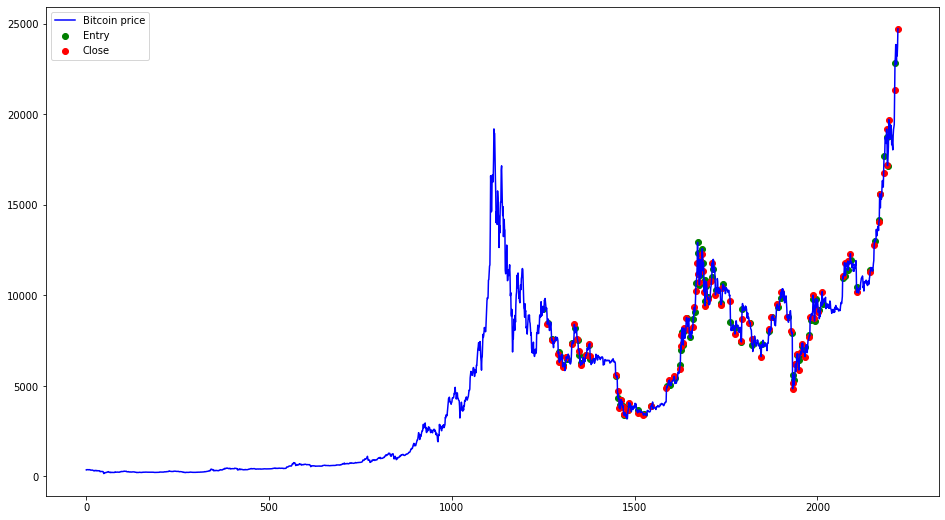

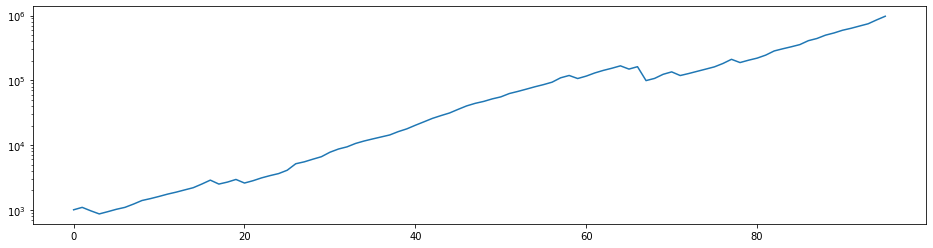

In [268]:
plt.figure(figsize=[16, 9])
plt.scatter(df['Entry date'], df_trade_show['Entry'], color='green', label='Entry')
plt.scatter(df['Close date'], df_trade_show['Close'], color='red', label='Close')
plt.plot(dataBot['open'], color='blue', label='Bitcoin price')
plt.legend()
plt.figure(figsize=[16, 4])
plt.plot(df_trade_show['Balance'], label="Balance evolution (log scale)")
plt.yscale("log")
plt.show()

En vert les entrées en position

En rouge les clotures de position

Le deuxieme plot représente l'évolution du portefeuille, il semblerait que le modele marche, cependant de nombreux concepts ne sont pas abordés et sa fiabilité reste limitée.

J'ai volontairement fait commencer le bot au milieu de l'année 2018 pour voir ses performances après que les bulles Cryptomonnaies aient lieu.


# Conclusion


---

Avec tous ces indicateurs et le modèle d'IA, il est possible de trouver une tendance globale du marché. Il me semble toutefois compliqué de trouver un stratégie gagnante sur le long terme.

De plus de nombreux sujets relatifs au trading ne sont pas traités.
* Le risk-management
* Les frais de réseau
* Les commissions des échangeurs
* Le levier
* Le spread
* ...


### Piste d'amélioration :

* Ajout d'une User interface
* Plus de choix d'indicateur
* Améliorer le modele d'IA
* Utiliser les données en temps réel
* ...